In [1]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.manager import SwarmManager
from backtester.exoinfo import EXOInfo

import pandas as pd
import numpy as np
import scipy

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
swarms = {}
for file in os.listdir('./temp_swarms/'):
    swarm_name = file.replace('.swm','')
    swarms[swarm_name] = SwarmManager.load(os.path.join('temp_swarms', file))

In [4]:
campaign_dict = {}
for swarm_name, smgr in swarms.items():
        smgr = swarms[swarm_name]
        campaign_dict[swarm_name] = smgr.swarm_picked.sum(axis=1)
   
    
campaign_portfolio = pd.DataFrame(campaign_dict)

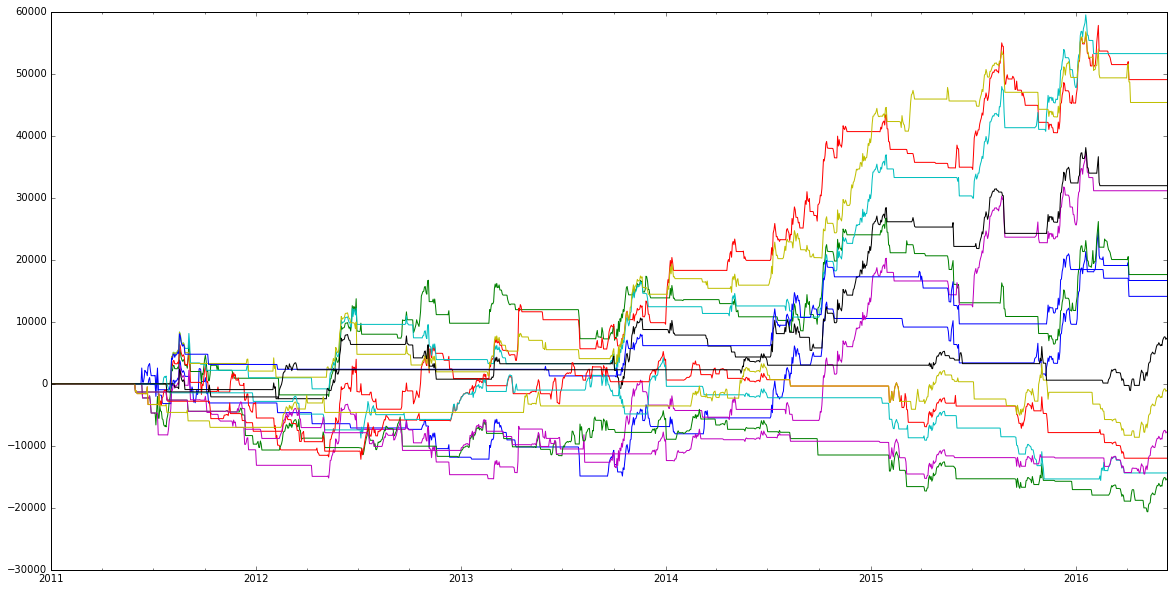

In [5]:
figsize(20,10)
campaign_portfolio.plot(legend=False)

## Rng strategies

In [6]:
#
# random time series
#
df = pd.DataFrame()
for i in range(10):
    
    date = pd.date_range(start='2015-01', end='2016-10', freq='D')
    price = np.random.randint(-100, 101, size=len(date))
    
    ser = pd.Series(price, index=date, name='rng_system'+str(i))
    df['rng_system'+str(i)] = ser.cumsum()

## Select input DF. Real swarms or RNG pseudo strategies

In [7]:
# Real swarms
#df = campaign_portfolio

# Rng strategies
df = df

# Real swarms from DF
#df = pd.read_csv('./swarms_df/ichi_swarms_df.csv', parse_dates=[0],
#                dayfirst=True, index_col=0).asfreq('D')

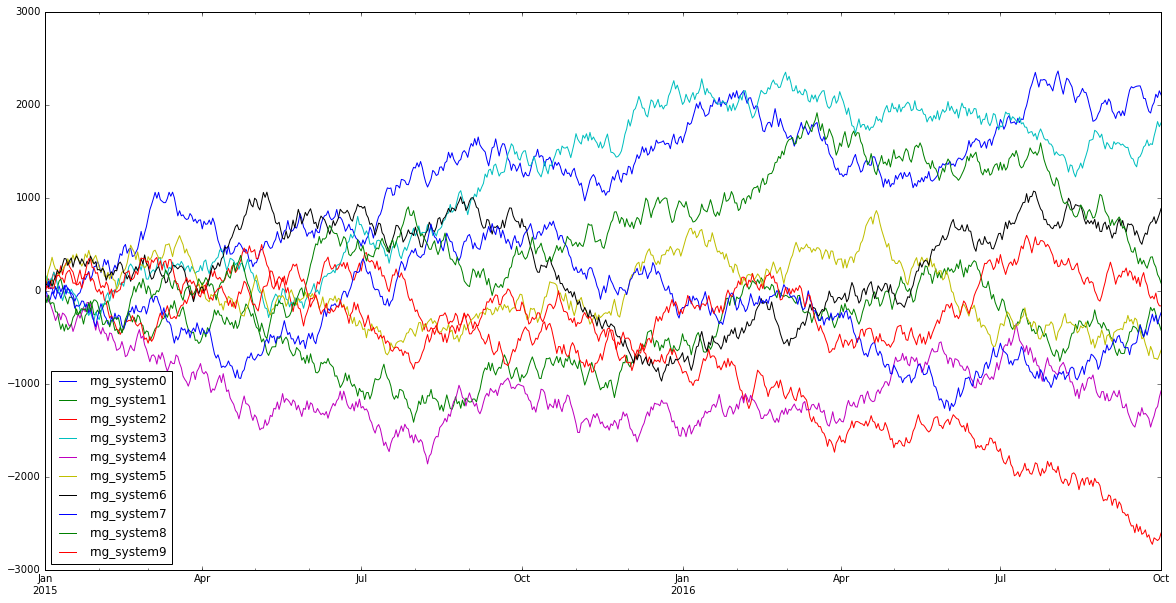

In [8]:
df.plot()

# Metrics calculation

In [9]:
#
# Rebalance triggers
#
# Rebalance trigger must be array of Datetime indexes when event occurred, like date of monday or new month
# 
newmonth = df[df.index.month != df.index.shift(1).month].index

monday = df[df.index.weekday == 0].index

norebalance = [df.index[-1]]

newyear = df[df.index.year != df.index.shift(1).year].index
#
#
#

# note: I think more performance metrics for strategies is better
# https://www.amibroker.com/guide/h_report.html for reference

rebalance_index = 1
rebalance_date_start = None

rebalance_trigger = monday # set rebalance trigger here

temp_l = []

for reb_idx in rebalance_trigger:
    
    for strat in df.columns:

        if rebalance_index == 1:
            rebalance_date_start = df.index[0]
           
        for i in range(len(df[strat])):

            if df[strat].index[i] == reb_idx:

                input_strategy_data = df[strat].ix[rebalance_date_start:reb_idx] # This data is used in metrics calc
                
                price_change = input_strategy_data.diff()
                max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
                netprofit = df[strat].ix[reb_idx] - df[strat].ix[rebalance_date_start]
                
                # Since swarm PnL statistics is not trade-by-trade
                # For PF calc I used cumulative values of positive and negatives price changes
                # Same for winrate
                profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())
                
                winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               
                # If all trades are negative, PF is 0. But later all 0s is replaced with NaN. 
                # To avoid replacing true 0.0 PF set it to 0.000001
                # This made for handling missing data 
                
                # Also winrate can be 0.0, but if PF is NaN - no trades were made
                # This made for handling missing data 
                
                if winrate == 0.0 and np.isnan(profit_factor) == False:
                    winrate = 0.000001
                
                elif winrate == 0.0 and np.isnan(profit_factor) == True:
                    winrate = np.nan
                                
                if profit_factor == 0.0:
                    profit_factor = 0.000001                
                          
                try:
                    modsharpe = np.mean(price_change) / np.std(price_change)
                    
                except ZeroDivisionError:
                    modsharpe = np.nan
            
                
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_netprofit': netprofit,
                    'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
                    'stats_profit_factor': profit_factor, 'stats_winrate': winrate }
                
                '''
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_recovery_factor': netprofit / np.abs(max_dd)}
                '''
                
                temp_l.append(d)
    
    rebalance_index += 1
    rebalance_date_start = reb_idx # set new start rebalance date to current rebalance trigger date

### Data cleaning

In [10]:
# Replacing 0 values with NaNs
# If strategy stats is 0 means that no trades were made
stats_df = pd.DataFrame(temp_l).replace(0, np.nan)

# Filling NaNs with last avaible values
for s in stats_df.strategy.unique():
    stats_df[stats_df.strategy == s] = stats_df[stats_df.strategy == s].fillna(method='pad')

stats_df = stats_df.dropna(how='any')

In [11]:
stats_df

,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy
0,2015-01-05,2015-01-01,1,-120.0,-15.0,-0.059993,0.875000,-0.125000,50.000000,rng_system0
1,2015-01-05,2015-01-01,1,-48.0,100.0,0.527457,3.083333,2.083333,75.000000,rng_system1
2,2015-01-05,2015-01-01,1,-74.0,103.0,0.404813,2.391892,1.391892,75.000000,rng_system2
3,2015-01-05,2015-01-01,1,-85.0,50.0,0.195450,1.581395,0.588235,50.000000,rng_system3
4,2015-01-05,2015-01-01,1,-153.0,-153.0,-2.054293,0.000001,-1.000000,0.000001,rng_system4
6,2015-01-05,2015-01-01,1,-56.0,-36.0,-0.197862,0.647059,-0.642857,25.000000,rng_system6
7,2015-01-05,2015-01-01,1,-80.0,-42.0,-0.185290,0.655738,-0.525000,50.000000,rng_system7
8,2015-01-05,2015-01-01,1,-114.0,-96.0,-0.314878,0.505155,-0.842105,50.000000,rng_system8
9,2015-01-05,2015-01-01,1,-31.0,69.0,0.374541,3.156250,2.225806,50.000000,rng_system9
10,2015-01-12,2015-01-05,2,-79.0,27.0,0.072825,1.168750,0.341772,42.857143,rng_system0


## Statistics rank calculation

In [12]:
rank_scores_l = []
rank_summary_l = []

for i in stats_df.rebalance_index.unique():

    for strat in stats_df[stats_df.rebalance_index == i].strategy:

        for col in stats_df[stats_df.rebalance_index == i].columns:
            if 'stats' in col:

                # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
                metric_quantile0 = stats_df[col].quantile(0.0)
                metric_quantile10 = stats_df[col].quantile(0.1)
                metric_quantile20 = stats_df[col].quantile(0.2)
                metric_quantile30 = stats_df[col].quantile(0.3)
                metric_quantile40 = stats_df[col].quantile(0.4)
                metric_quantile50 = stats_df[col].quantile(0.5)
                metric_quantile60 = stats_df[col].quantile(0.6)
                metric_quantile70 = stats_df[col].quantile(0.7)
                metric_quantile80 = stats_df[col].quantile(0.8)
                metric_quantile90 = stats_df[col].quantile(0.9)
                metric_quantile100 = stats_df[col].quantile(1)

                # Define strategy statistics rank of certain strategy

                strategy_stats_metric = stats_df[(stats_df.rebalance_index == i) 
                                                 & (stats_df.strategy == strat)][col].values[0]

                if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric < metric_quantile10:
                    rank_scores_l.append(0)

                elif strategy_stats_metric > metric_quantile10 and strategy_stats_metric < metric_quantile20:
                    rank_scores_l.append(1)

                elif strategy_stats_metric > metric_quantile20 and strategy_stats_metric < metric_quantile30:
                    rank_scores_l.append(2)

                elif strategy_stats_metric > metric_quantile30 and strategy_stats_metric < metric_quantile40:
                    rank_scores_l.append(3)

                elif strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50:
                    rank_scores_l.append(4)

                elif strategy_stats_metric > metric_quantile50 and strategy_stats_metric < metric_quantile60:
                    rank_scores_l.append(5)

                elif strategy_stats_metric > metric_quantile60 and strategy_stats_metric < metric_quantile70:
                    rank_scores_l.append(6)

                elif strategy_stats_metric > metric_quantile70 and strategy_stats_metric < metric_quantile80:
                    rank_scores_l.append(7)

                elif strategy_stats_metric > metric_quantile80 and strategy_stats_metric < metric_quantile90:
                    rank_scores_l.append(8)

                elif strategy_stats_metric > metric_quantile90 and strategy_stats_metric < metric_quantile100:
                    rank_scores_l.append(9)

                elif strategy_stats_metric == metric_quantile100:
                    rank_scores_l.append(10)

                # For debugging purposes

                #print(i)
                #print(col)
                #print('50 quantile---',metric_quantile50)
                #print(strat)
                #print(strategy_stats_metric)
        #print('rank_score------', np.sum(rank_scores_l))

    
        rank_summary_l.append(np.sum(rank_scores_l))        
        rank_scores_l = []
    print('rebalance index ---', i)

rebalance index --- 1
rebalance index --- 2
rebalance index --- 3
rebalance index --- 4
rebalance index --- 5
rebalance index --- 6
rebalance index --- 7
rebalance index --- 8
rebalance index --- 9
rebalance index --- 10
rebalance index --- 11
rebalance index --- 12
rebalance index --- 13
rebalance index --- 14
rebalance index --- 15
rebalance index --- 16
rebalance index --- 17
rebalance index --- 18
rebalance index --- 19
rebalance index --- 20
rebalance index --- 21
rebalance index --- 22
rebalance index --- 23
rebalance index --- 24
rebalance index --- 25
rebalance index --- 26
rebalance index --- 27
rebalance index --- 28
rebalance index --- 29
rebalance index --- 30
rebalance index --- 31
rebalance index --- 32
rebalance index --- 33
rebalance index --- 34
rebalance index --- 35
rebalance index --- 36
rebalance index --- 37
rebalance index --- 38
rebalance index --- 39
rebalance index --- 40
rebalance index --- 41
rebalance index --- 42
rebalance index --- 43
rebalance index --- 

In [13]:
stats_df['rank_score'] = rank_summary_l

In [14]:
stats_df

,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
0,2015-01-05,2015-01-01,1,-120.0,-15.0,-0.059993,0.875000,-0.125000,50.000000,rng_system0,26
1,2015-01-05,2015-01-01,1,-48.0,100.0,0.527457,3.083333,2.083333,75.000000,rng_system1,49
2,2015-01-05,2015-01-01,1,-74.0,103.0,0.404813,2.391892,1.391892,75.000000,rng_system2,47
3,2015-01-05,2015-01-01,1,-85.0,50.0,0.195450,1.581395,0.588235,50.000000,rng_system3,36
4,2015-01-05,2015-01-01,1,-153.0,-153.0,-2.054293,0.000001,-1.000000,0.000001,rng_system4,4
6,2015-01-05,2015-01-01,1,-56.0,-36.0,-0.197862,0.647059,-0.642857,25.000000,rng_system6,20
7,2015-01-05,2015-01-01,1,-80.0,-42.0,-0.185290,0.655738,-0.525000,50.000000,rng_system7,21
8,2015-01-05,2015-01-01,1,-114.0,-96.0,-0.314878,0.505155,-0.842105,50.000000,rng_system8,17
9,2015-01-05,2015-01-01,1,-31.0,69.0,0.374541,3.156250,2.225806,50.000000,rng_system9,44
10,2015-01-12,2015-01-05,2,-79.0,27.0,0.072825,1.168750,0.341772,42.857143,rng_system0,27


### Strategies picker

In [108]:
# Trade-by-trade pnl
pnl_df = df.diff()

summary_best_eqty = pd.Series()
summary_worst_eqty = pd.Series()
benchmark_eqty = pd.Series()
# We can set start rebalance index value to 
for i in range(stats_df.rebalance_index.unique().min(),stats_df.rebalance_index.unique().max()):
    
    if i < 2:
        # We must estimate strategies preformance at least on one rebalance window
        continue
        
    else:

        # Pick strats from previous rebalance, but trade them until next rebalance
                        
        start_date = stats_df[stats_df.rebalance_index == i].rebalance_date_start.values[0]  
        end_date = stats_df[stats_df.rebalance_index == i].rebalance_date_end.values[0]
        
        # Number of picked strats defined by .strategy.values[:number]
        # Remove -1 from 'i - 1' to get holy grail :D (future reference)
        
        picked_best_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:3]
        
        picked_worst_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[-5:]
        
        all_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:]
        
        if len(summary_best_eqty) == 0 and len(summary_worst_eqty) == 0 and len(benchmark_eqty) == 0:
            summary_best_eqty = df[picked_best_strats].ix[start_date : end_date].sum(axis=1)           
            summary_worst_eqty = pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1)
            
            benchmark_eqty = pnl_df[all_strats].ix[start_date : end_date].sum(axis=1)      
            
        else:
            summary_best_eqty = summary_best_eqty.append(pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1))
            summary_worst_eqty = summary_worst_eqty.append(pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1))
            
            benchmark_eqty = benchmark_eqty.append(pnl_df[all_strats].ix[start_date : end_date].sum(axis=1))
            
        
best_portfolio = summary_best_eqty.cumsum()
worst_portfolio = summary_worst_eqty.cumsum() * -1 # Reversed

summary_portfolio = best_portfolio + worst_portfolio

benchmark_portfolio = benchmark_eqty.cumsum()

## Comparing portfolios stats with benchmark(all strategies equity)

In [109]:
def portfolio_stats(portfolio_ser,label):
    input_data = portfolio_ser # This data is used in metrics calc
                
    price_change = input_data.diff()
    max_dd = (input_data - input_data.expanding().max()).min()
    netprofit = input_data.ix[input_data.index[-1]] - input_data.ix[input_data.index[0]]

    # Since swarm PnL statistics is not trade-by-trade
    # For PF calc I used cumulative values of positive and negatives price changes
    # Same for winrate
    profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

    winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

    modsharpe = np.mean(price_change) / np.std(price_change)

    recovery_factor = netprofit / np.abs(max_dd)

    print('Portfolio name ---', str(label))
    print('\n')
    print('PriceChange Mod. Sharpe', modsharpe)
    print('Netprofit',netprofit)
    print('Max DD', max_dd)
    print('Recovery Factor', recovery_factor)
    print('Profit factor', profit_factor)
    print('Winrate', winrate)

    input_data.plot(kind='area', stacked=False)

Portfolio name --- Best


PriceChange Mod. Sharpe 0.13290798254660485
Netprofit 10205.0
Max DD -1169.0
Recovery Factor 8.72968349016
Profit factor 1.40592680986
Winrate 53.7271448664


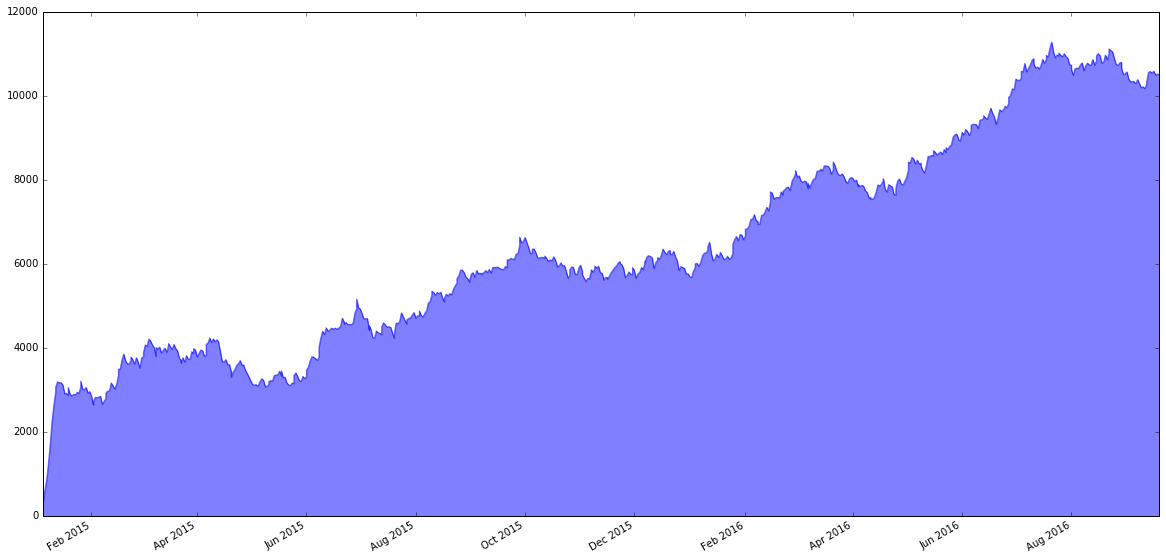

In [110]:
portfolio_stats(best_portfolio, 'Best')

Portfolio name --- Worst(reversed)


PriceChange Mod. Sharpe 0.08668054807825021
Netprofit 8452.0
Max DD -2726.0
Recovery Factor 3.100513573
Profit factor 1.23972544459
Winrate 52.4613220816


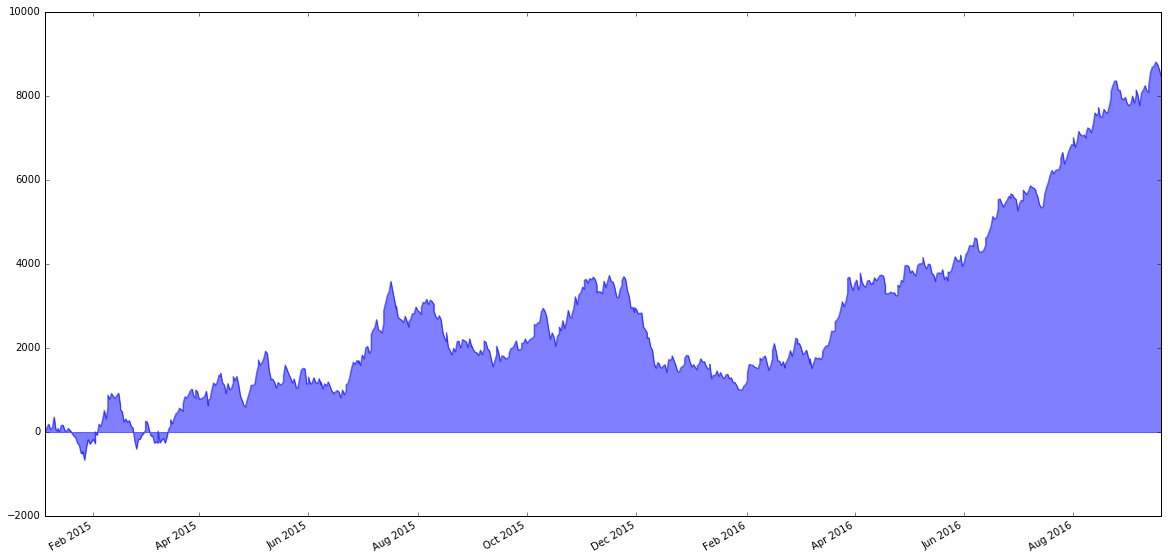

In [111]:
portfolio_stats(worst_portfolio, 'Worst(reversed)')

Portfolio name --- Summary(Best + Worst)


PriceChange Mod. Sharpe 0.14606346974242224
Netprofit 18657.0
Max DD -2449.0
Recovery Factor 7.6182115149
Profit factor 1.43971246759
Winrate 56.1181434599


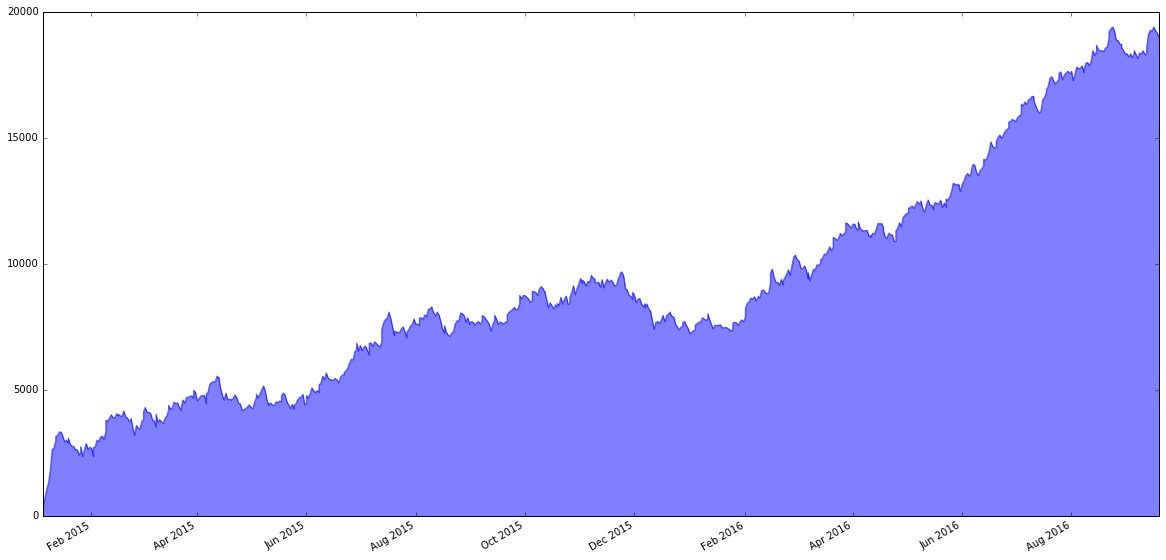

In [113]:
portfolio_stats(summary_portfolio, 'Summary(Best + Worst)')

Portfolio name --- Benchmark


PriceChange Mod. Sharpe -0.004794564155193463
Netprofit -641.0
Max DD -4671.0
Recovery Factor -0.137229715264
Profit factor 0.988240258311
Winrate 49.2264416315


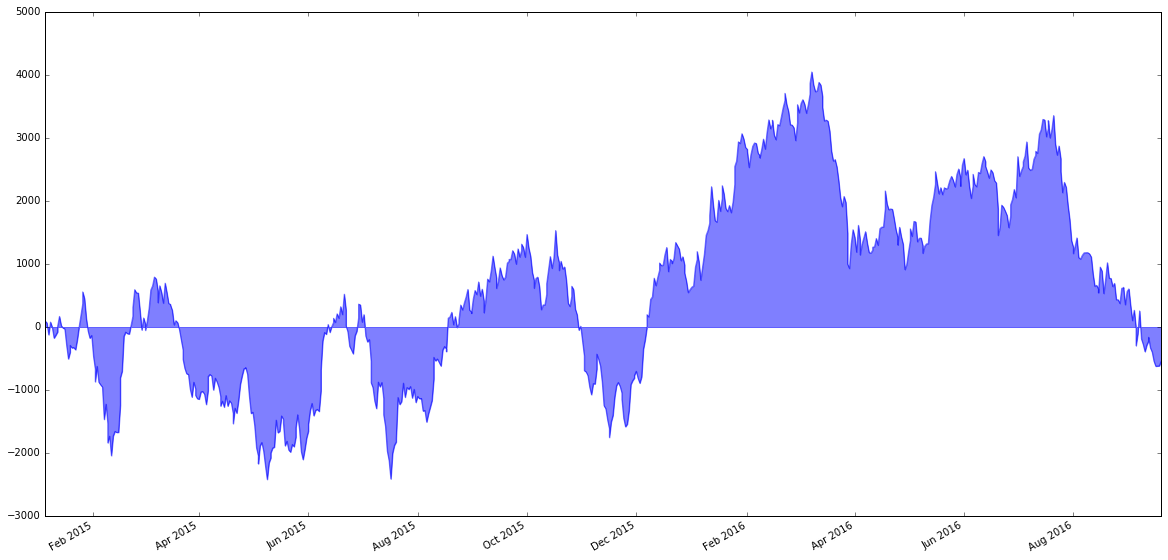

In [114]:
portfolio_stats(benchmark_portfolio, 'Benchmark')